Some background from Leif's email: \
Leif is discussing the use of SRAnal710e.sh – the hyperspectral viewing software that can read .cube files
> Finally, you can save the reflectance image as 'float' values that you can read into a package such as ENVI using 'File->Save Float'. You can't actually read this image back into SR/SXAnalysis unfortunately, and the 'File->Save' command won't save a calibrated image, just a raw image with modified settings.

# **Script Goals**
1. Crop the calibrated hyperspectral .float files
2. Save the cropped file as a .npy

# **Step 0:** Perform normalization with SXAnalysis

# **Step 1:** read float files with ENVI


## **Step 1.5:** 
Change the filename to the 

In [541]:
import spectral.io.envi as envi

# Change this filename each time you go through the script
filename = 'CT30_1'
directory = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick_Sunscreen Images/Sunscreen 1/'
filepath = directory + filename + '.float'
HDRpath = directory + filename + '.hdr'

# Open the image using the envi hyperspectral toolkit
img = envi.open(HDRpath, filepath)
print(img)
print(img.shape)

	Data Source:   '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick_Sunscreen Images/Sunscreen 1/CT30_1.float'
	# Rows:            520
	# Samples:         696
	# Bands:           128
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32
(520, 696, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


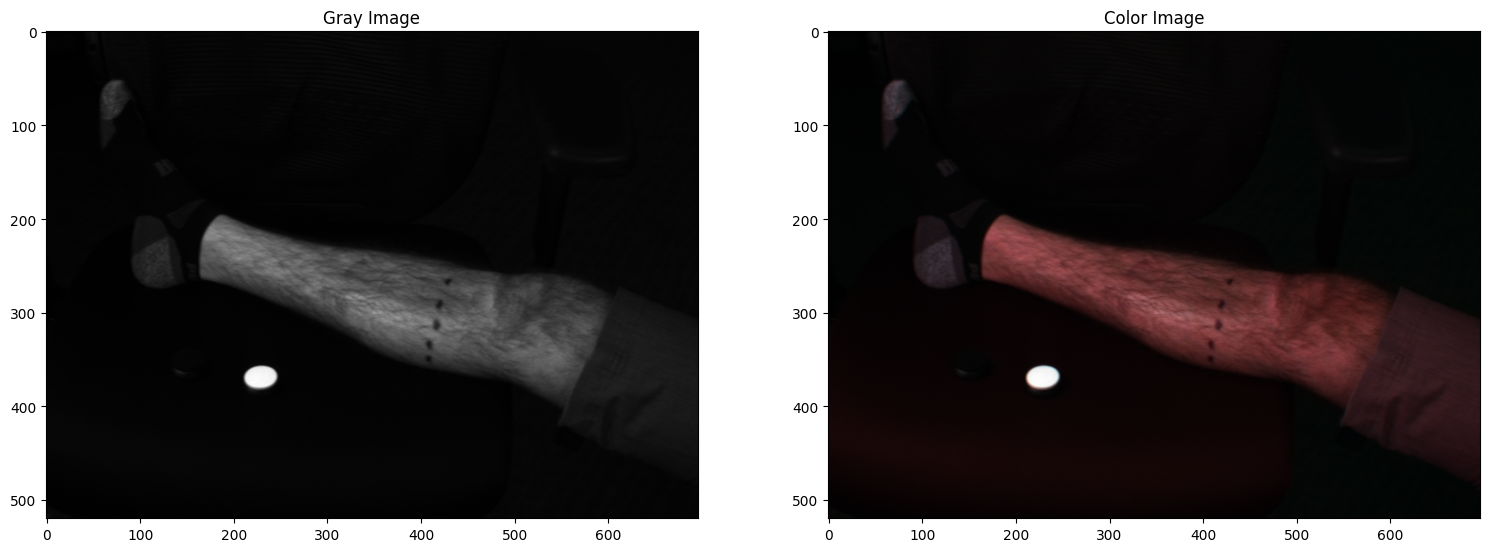

In [542]:
import matplotlib.pyplot as plt
import numpy as np

# Setup plot with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5) #plot it big!

# Plot grey image
img_grey = img[:,:,49:50] #pull grey bands
ax1.imshow(img_grey, cmap='gray')
ax1.set_title('Gray Image')

# Pull Color bands
img_red = img[:,:,20]
img_green = img[:,:,35]
img_blue = img[:,:,60]

# Combine color bands
img_color = np.dstack((img_blue, img_green,img_red))

#Plot color image
ax2.imshow(img_color)
ax2.set_title('Color Image')
plt.show()

There will be an error saying "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)." Our data is from 0 to 1 and some of the values will be very slightly over 1. For example: 1.0356554 1.0142472. This should not be a problem for how the model is trained, rather it only throws a non-fatal error during data display.

# **Step 2:** Save the Image file as .PNG and then use Preview to mask the image

In [543]:
import numpy as np
from PIL import Image

# Ensure that the maximum of the image is 255 (PNG has 256 different colors - including 0)
max = img_color.max()
scale = 255 / max
image = Image.fromarray(np.uint8(img_color * scale))

# Save Image
PNGfilepath = directory + filename + 'output.png'
image.save(PNGfilepath)
print(f'Image saved at {PNGfilepath}')

Image saved at /Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick_Sunscreen Images/Sunscreen 1/CT30_1output.png


# **Step 3.5**: 
 * Open Preview
 * Use the lasso selection tool to select a region to cut out of image (Any part of image that is not exposed skin on leg)
 * **you cannot use the cropping function because this will cause the dimensions of the photo to change** – this will result in the code not funcitoning properly
 * Save the file and run next steps

# **Step 4**: Wherever the masked .PNG file is black Make the cube also be black

In [544]:
image = Image.open(PNGfilepath)
# Convert the image to RGBA mode if it's not already
if image.mode != "RGBA":
    image = image.convert("RGBA")
    print('Image was converted to RGBA')

# Get the image data as a NumPy array
PNG_NP = image.load() #___change to PNG_NP

# Define the green color you want to use
green = (0, 255, 0, 255)  # RGBA format (R, G, B, A)

# Convert the img to a numpy array
masked = img[:,:,:]

# Iterate through the image pixels and change transparent ones to green
for x in range(image.width):
    for y in range(image.height):
        r, g, b, a = PNG_NP[x, y]
        if a == 0 or (r==0 and g==0 and b==0): #if cropped out or black
            PNG_NP[x, y] = green #change 
            # also change cube to black
            for band in range(masked.shape[2]): # Loop over each band
                masked[y][x][band] = 0

# Save the png file with a green background so we can see our crops clearly
image.save(directory + filename + 'GreenOutput.png')

## **Step 4.5:**
Verify that the GreenOutput.png is the correct crop 

# **Step 5:** Display 'masked' to make sure we did it correctly

(520, 696, 128)
masked shape: (520, 696, 128)
masked_grey shape: (520, 696, 1)
masked_grey shape: (520, 696, 1)
masked_red shape: (520, 696)
np_pixel_color shape (520, 696, 3)


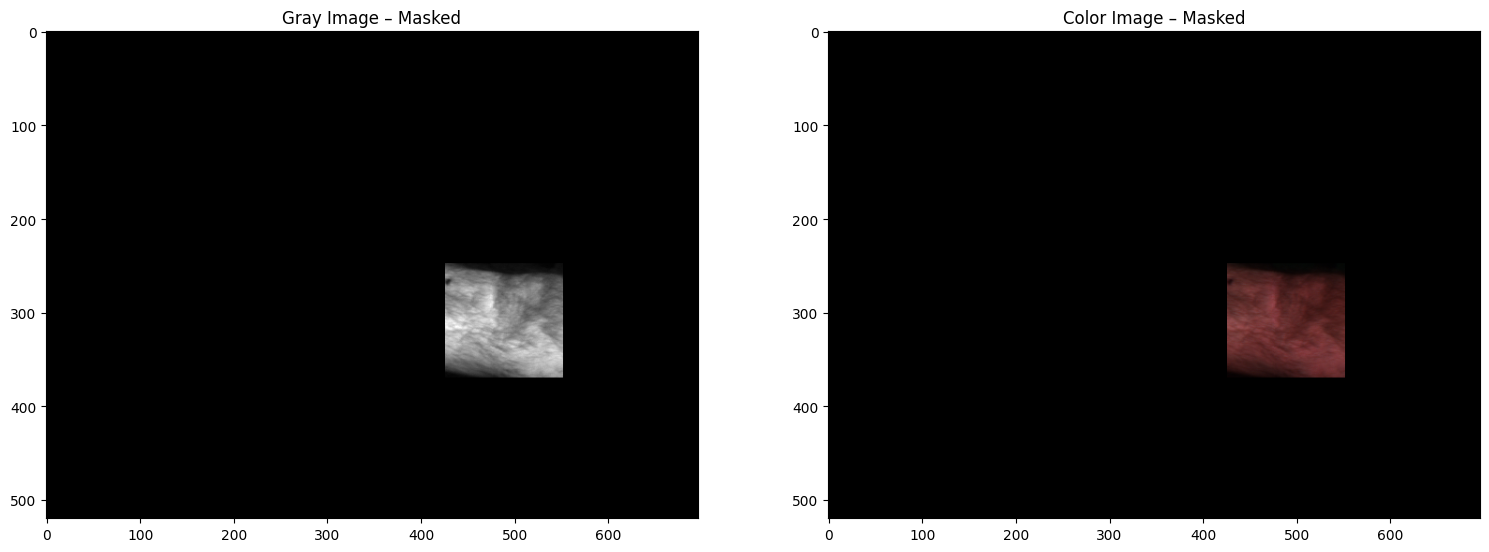

In [545]:
print(masked.shape)

# Create a new figure with two subplots
fig, (ax3, ax4) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5) #plot it big!


# Only display the 49th band in gray
masked_grey = masked[:, :, 49:50]
print('masked shape:', masked.shape)

print(f'masked_grey shape: {masked_grey.shape}')
masked_grey.squeeze()
print(f'masked_grey shape: {masked_grey.shape}')

# Display the gray image in the first subplot
ax3.imshow(masked_grey, cmap='gray')
ax3.set_title('Gray Image – Masked')

# Grab the colored bands
masked_red = masked[:,:,20]
masked_green = masked[:,:,35]
masked_blue = masked[:,:,60]

# # Normalize the bands to [0, 1] for each color channel
# masked_red = (masked_red - np.min(masked_red)) / (np.max(masked_red) - np.min(masked_red))
# masked_green = (masked_green - np.min(masked_green)) / (np.max(masked_green) - np.min(masked_green))
# masked_blue = (masked_blue - np.min(masked_blue)) / (np.max(masked_blue) - np.min(masked_blue))

print('masked_red shape:', masked_red.shape)

masked_color = np.dstack((masked_blue,masked_green,masked_red))
print('np_pixel_color shape',masked_color.shape)

# Display the color image in the second subplot
ax4.imshow(masked_color)
ax4.set_title('Color Image – Masked')

# Show the figure with both subplots
plt.show()

# **Step 6:** Explore the cropped data
Adjust the slider to the band you want to see

In [546]:
from ipywidgets import interact

def interactive_plot(band):
    # Create a new figure with two subplots
    fig, (ax5, ax4) = plt.subplots(1, 2)

    # Only display the 49th band in gray
    grey_band = masked[:, :, band:(band + 1)]
    print('Grey_bands shape:', grey_band.shape)

    # Display the gray image in the first subplot
    ax5.imshow(grey_band, cmap='gray')
    ax5.set_title(f'Gray Image – Masked (band = {band})')

    # Display the color image in the second subplot
    ax4.imshow(masked_color)
    ax4.set_title('Color Image – Masked')

    # Show the figure with both subplots
    plt.show()

interact(interactive_plot, band=(0, 127, 1))

interactive(children=(IntSlider(value=63, description='band', max=127), Output()), _dom_classes=('widget-inter…

<function __main__.interactive_plot(band)>

# **Step 7:** Now Save the Float as a .npy
So it can be easily loaded into a model

In [547]:
## For same output location as input:
# OutputPath = directory + filename + '.npy'

## For different output location as input:
OutputPath = "/Users/maycaj/Documents/Hyperspectral-Imaging_II/Sunscreen Input/Upper Leg/" + filename + '_sunscreen.npy'


print(f'Saving to {OutputPath}')
np.save(OutputPath, masked)
print(masked.dtype)

Saving to /Users/maycaj/Documents/Hyperspectral-Imaging_II/Sunscreen Input/Upper Leg/CT30_1_sunscreen.npy
float32


Now load the .npy file and view it

Text(0.5, 1.0, 'Gray Image –\xa0Masked')

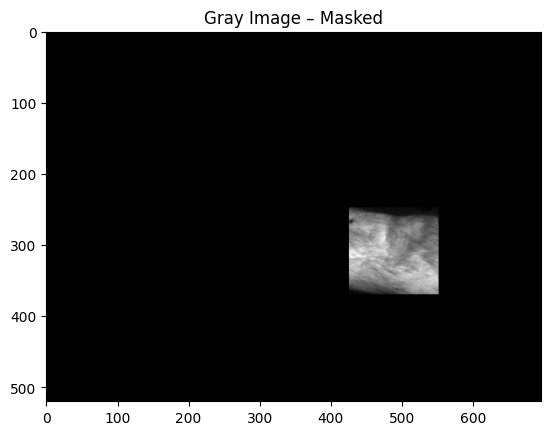

In [548]:
#Load the NPY file
pixel_loaded = np.load(OutputPath)
# Display the NPY file
fig, ax = plt.subplots()
ax.imshow(pixel_loaded[:, :, 49:50], cmap='gray')
ax.set_title('Gray Image – Masked')

# **Step 8:** Ensure data is being saved in the correct type

In [549]:
print(f'Loaded datatype: {pixel_loaded.dtype}')
if pixel_loaded.dtype == 'float32':
    print('pixel_loaded has correct datatype')
else:
    raise Exception('INCORRECT DATATYPE')

Loaded datatype: float32
pixel_loaded has correct datatype
